<a href="https://colab.research.google.com/github/CarlosModinez/brazilian_weeds/blob/main/weed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Utils**
Don't run it if your dataset is structured

In [ ]:
import shutil

DATASET_PATH = "drive/My Drive/TCC/brazilian_weeds_2020"
classes = os.listdir(DATASET_PATH)

def search_images(path, image_paths=[]):
    image_extensions = ['jpg', 'jpeg']

    if os.path.exists(path) and os.path.isdir(path):
        for file in os.listdir(path):
            file_extension = file.split(".")[-1].lower()
            if file_extension in image_extensions:
                  image_paths.append(os.path.join(path, file))
            elif os.path.isdir(os.path.join(path, file)):
                search_images(os.path.join(path, file), image_paths)
    return image_paths

def get_class(image_path, classes):
  for plant_class in classes:
    if plant_class.lower() in image_path.lower():
      return plant_class
  return None

def build_dataset(dataset_path, classes):
  image_paths = search_images(dataset_path)

  for image_path in image_paths:
    label = get_class(image_path, classes)
    destination_path = "drive/My Drive/TCC/brazilian_weeds_2020_classification/" + label + "/"

    if not os.path.exists(destination_path):
      os.makedirs(destination_path)

    shutil.copy(image_path, destination_path)

build_dataset(DATASET_PATH, classes)

## Classifier

In [ ]:
DATASET_PATH = "drive/My Drive/TCC/brazilian_weeds_2020_classification"
os.listdir(DATASET_PATH)

['Amaranthaceae',
 'Asteraceae',
 'Lamiaceae',
 'Convolvulaceae',
 'Solanaceae',
 'Poaceae',
 'Apiaceae',
 'Brassicaceae']

In [ ]:
img_height = 1040
img_width = 1040
batch_size = 32

full_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  shuffle=True,
  seed=123  # Set seed for reproducibility
)

total_samples = len(full_ds)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Found 752 files belonging to 8 classes.


In [ ]:
class_names = full_ds.class_names
class_names

['Amaranthaceae',
 'Apiaceae',
 'Asteraceae',
 'Brassicaceae',
 'Convolvulaceae',
 'Lamiaceae',
 'Poaceae',
 'Solanaceae']

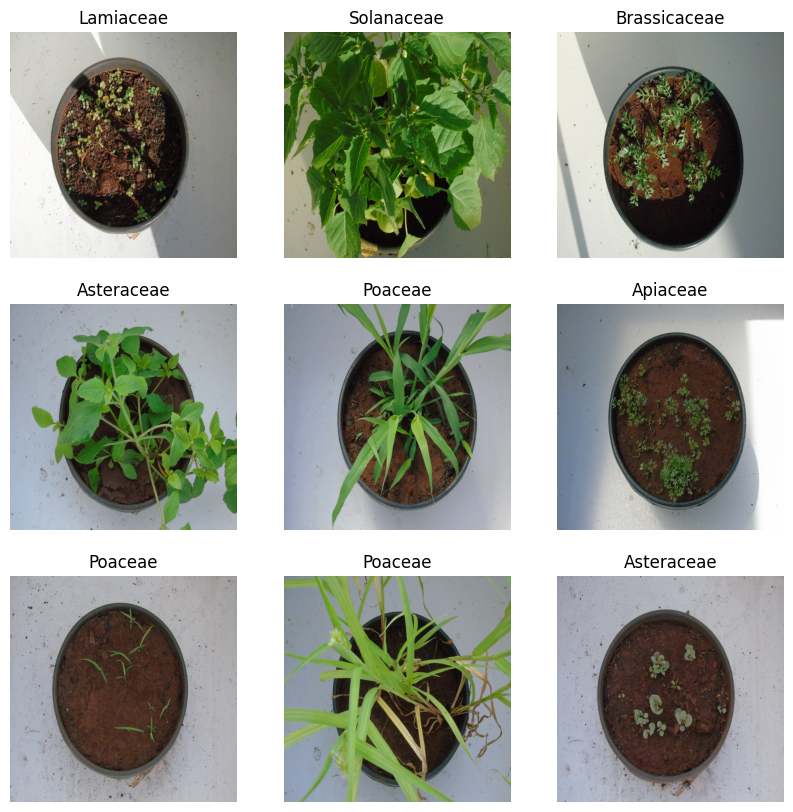

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_width,img_height,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
METRICS = [
  keras.metrics.BinaryCrossentropy(name='cross entropy'),
  keras.metrics.MeanSquaredError(name='Brier score'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'),
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR')
]

## Loss: SparseCategoricalCrossentropy
It's not property for imbalanced data

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
16/16 [==============================] - 51s 2s/step - loss: 3.1112 - accuracy: 0.3047 - val_loss: 1.8245 - val_accuracy: 0.3646
Epoch 2/15
16/16 [==============================] - 6s 357ms/step - loss: 1.8242 - accuracy: 0.3516 - val_loss: 1.8961 - val_accuracy: 0.3646
Epoch 3/15
16/16 [==============================] - 6s 357ms/step - loss: 1.8426 - accuracy: 0.3516 - val_loss: 1.8332 - val_accuracy: 0.3646
Epoch 4/15
16/16 [==============================] - 6s 357ms/step - loss: 1.8093 - accuracy: 0.3516 - val_loss: 1.8390 - val_accuracy: 0.3646
Epoch 5/15
16/16 [==============================] - 6s 357ms/step - loss: 1.8325 - accuracy: 0.3281 - val_loss: 1.8093 - val_accuracy: 0.3646
Epoch 6/15
16/16 [==============================] - 6s 357ms/step - loss: 1.8017 - accuracy: 0.3516 - val_loss: 1.7864 - val_accuracy: 0.3646
Epoch 7/15
16/16 [==============================] - 6s 357ms/step - loss: 1.7620 - accuracy: 0.3711 - val_loss: 1.7573 - val_accuracy: 0.3542
Epoch 8/

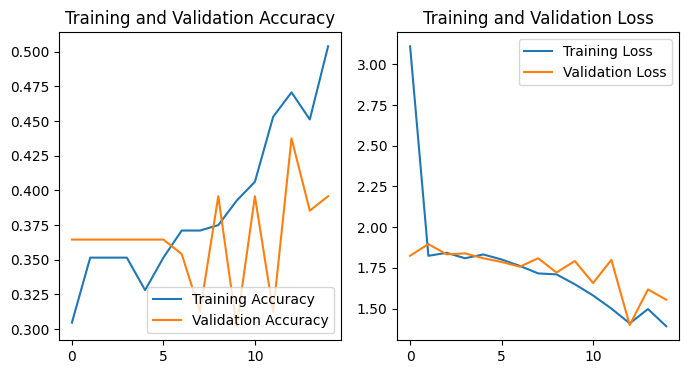

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Assuming you have loaded your test dataset into the variable test_ds

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

5/5 [==============================] - 32s 278ms/step


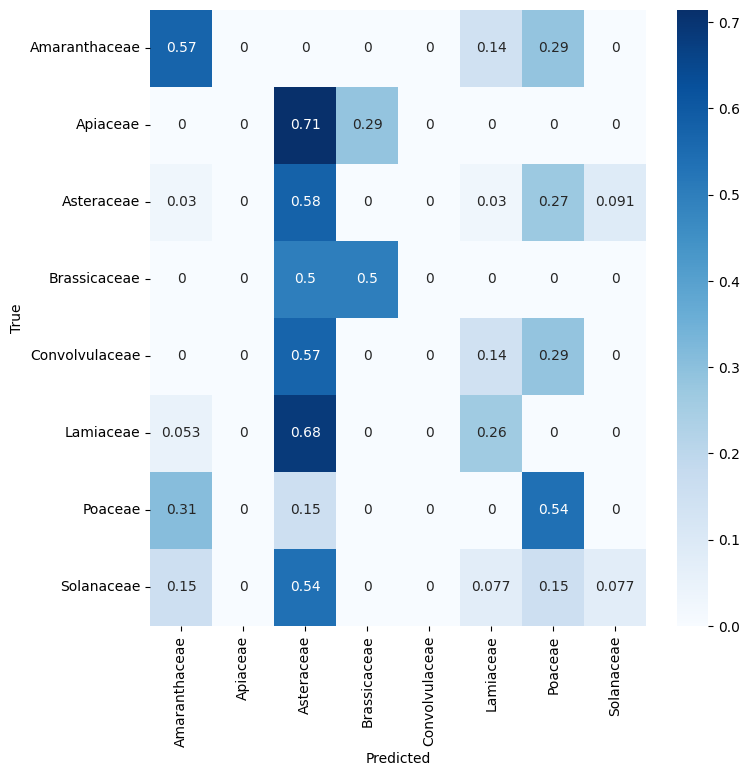

                precision    recall  f1-score   support

 Amaranthaceae       0.17      0.57      0.26         7
      Apiaceae       0.00      0.00      0.00         7
    Asteraceae       0.32      0.58      0.41        33
  Brassicaceae       0.60      0.50      0.55         6
Convolvulaceae       0.00      0.00      0.00         7
     Lamiaceae       0.56      0.26      0.36        19
       Poaceae       0.65      0.54      0.59        52
    Solanaceae       0.25      0.08      0.12        13

      accuracy                           0.42       144
     macro avg       0.32      0.32      0.29       144
  weighted avg       0.44      0.42      0.40       144



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))


## Focal loss
It's supposed to be better for imbalanced data

In [ ]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        self.alpha = alpha
        self.gamma = gamma
        super(FocalLoss, self).__init__(**kwargs)

    def call(self, y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        pt = tf.math.exp(-ce_loss)
        focal_loss = self.alpha * tf.math.pow(1.0 - pt, self.gamma) * ce_loss
        return focal_loss

model.compile(
    optimizer='adam',
    loss=FocalLoss(),
    metrics=['accuracy']
)

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
16/16 [==============================] - 9s 391ms/step - loss: 0.2209 - accuracy: 0.4941 - val_loss: 0.2336 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 6s 358ms/step - loss: 0.2225 - accuracy: 0.5098 - val_loss: 0.2954 - val_accuracy: 0.3438
Epoch 3/30
16/16 [==============================] - 6s 357ms/step - loss: 0.2020 - accuracy: 0.5312 - val_loss: 0.2176 - val_accuracy: 0.5312
Epoch 4/30
16/16 [==============================] - 6s 359ms/step - loss: 0.1766 - accuracy: 0.5898 - val_loss: 0.1867 - val_accuracy: 0.5625
Epoch 5/30
16/16 [==============================] - 6s 359ms/step - loss: 0.1609 - accuracy: 0.6055 - val_loss: 0.2339 - val_accuracy: 0.4896
Epoch 6/30
16/16 [==============================] - 6s 359ms/step - loss: 0.1582 - accuracy: 0.6016 - val_loss: 0.2393 - val_accuracy: 0.5000
Epoch 7/30
16/16 [==============================] - 6s 359ms/step - loss: 0.1673 - accuracy: 0.5879 - val_loss: 0.1922 - val_accuracy: 0.5729
Epoch 

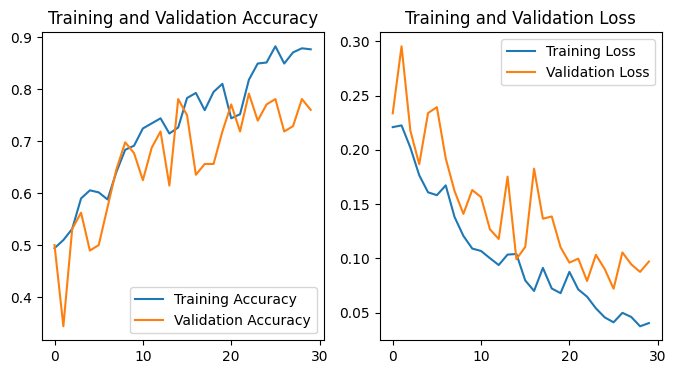

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

5/5 [==============================] - 1s 143ms/step


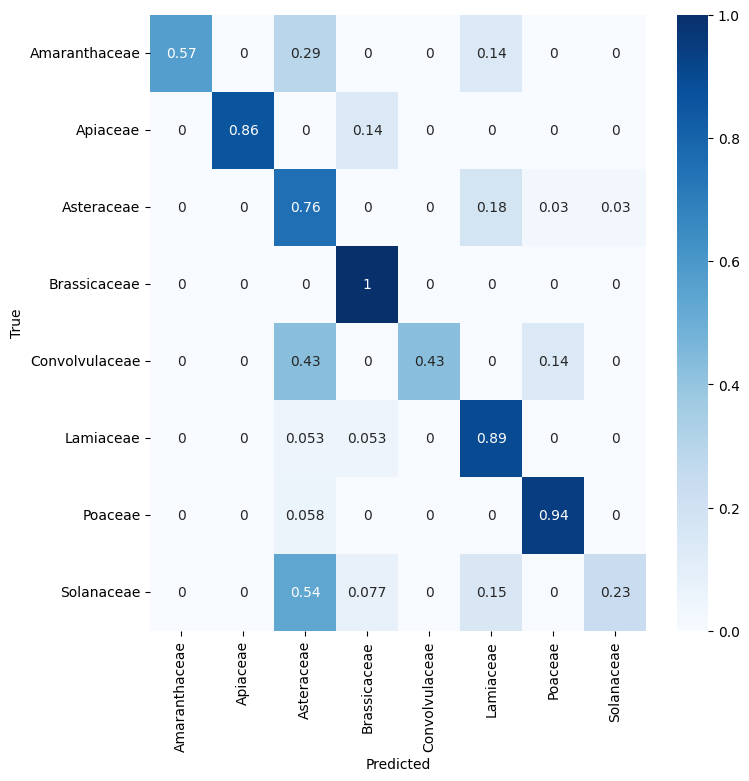

                precision    recall  f1-score   support

 Amaranthaceae       1.00      0.57      0.73         7
      Apiaceae       1.00      0.86      0.92         7
    Asteraceae       0.61      0.76      0.68        33
  Brassicaceae       0.67      1.00      0.80         6
Convolvulaceae       1.00      0.43      0.60         7
     Lamiaceae       0.65      0.89      0.76        19
       Poaceae       0.96      0.94      0.95        52
    Solanaceae       0.75      0.23      0.35        13

      accuracy                           0.78       144
     macro avg       0.83      0.71      0.72       144
  weighted avg       0.81      0.78      0.77       144



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))


## Weighted Cross-Entropy

In [ ]:
train_labels = np.array([])
for images, labels in train_ds.take(len(train_ds)):
  train_labels = np.concatenate((train_labels, labels.numpy()), axis=0)

train_labels

array([3., 2., 6., 3., 6., 7., 0., 2., 5., 2., 0., 3., 3., 1., 6., 3., 3.,
       0., 6., 7., 3., 2., 6., 7., 2., 6., 3., 6., 6., 2., 6., 1., 6., 7.,
       6., 7., 0., 6., 7., 2., 6., 2., 6., 5., 7., 6., 5., 5., 2., 6., 6.,
       2., 6., 7., 6., 7., 0., 6., 2., 2., 6., 2., 2., 0., 6., 2., 6., 6.,
       5., 1., 7., 1., 3., 6., 6., 4., 2., 2., 5., 6., 7., 2., 0., 6., 2.,
       1., 1., 6., 2., 6., 2., 2., 6., 6., 6., 2., 2., 6., 4., 6., 6., 2.,
       7., 2., 6., 4., 6., 1., 0., 1., 6., 6., 5., 6., 2., 0., 1., 3., 0.,
       6., 6., 2., 6., 3., 6., 4., 4., 6., 5., 7., 3., 5., 6., 3., 6., 4.,
       0., 2., 6., 6., 2., 3., 1., 2., 5., 5., 6., 6., 2., 7., 6., 1., 2.,
       2., 6., 3., 6., 6., 2., 3., 2., 4., 2., 6., 2., 2., 7., 3., 1., 2.,
       2., 2., 6., 2., 7., 1., 6., 1., 6., 0., 4., 5., 2., 6., 2., 0., 6.,
       1., 6., 6., 6., 6., 2., 1., 6., 0., 6., 6., 5., 6., 2., 2., 1., 2.,
       0., 2., 2., 6., 6., 3., 5., 1., 5., 0., 5., 5., 2., 0., 0., 0., 6.,
       5., 5., 2., 6., 6.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    loss_weights=class_weights
)

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
16/16 [==============================] - 8s 370ms/step - loss: 0.9153 - accuracy: 0.7891 - val_loss: 0.8523 - val_accuracy: 0.7917
Epoch 2/30
16/16 [==============================] - 6s 359ms/step - loss: 0.6319 - accuracy: 0.8574 - val_loss: 1.4940 - val_accuracy: 0.6667
Epoch 3/30
16/16 [==============================] - 6s 359ms/step - loss: 0.5365 - accuracy: 0.8750 - val_loss: 0.9804 - val_accuracy: 0.8333
Epoch 4/30
16/16 [==============================] - 6s 359ms/step - loss: 0.4093 - accuracy: 0.9004 - val_loss: 0.9877 - val_accuracy: 0.7812
Epoch 5/30
16/16 [==============================] - 6s 359ms/step - loss: 0.4157 - accuracy: 0.9043 - val_loss: 0.9299 - val_accuracy: 0.8229
Epoch 6/30
16/16 [==============================] - 6s 360ms/step - loss: 0.5130 - accuracy: 0.8770 - val_loss: 1.2594 - val_accuracy: 0.7604
Epoch 7/30
16/16 [==============================] - 6s 359ms/step - loss: 0.4880 - accuracy: 0.8887 - val_loss: 0.8222 - val_accuracy: 0.8125
Epoch 

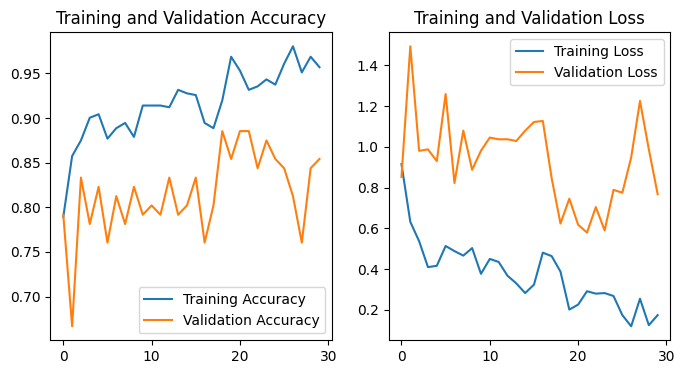

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

5/5 [==============================] - 1s 143ms/step


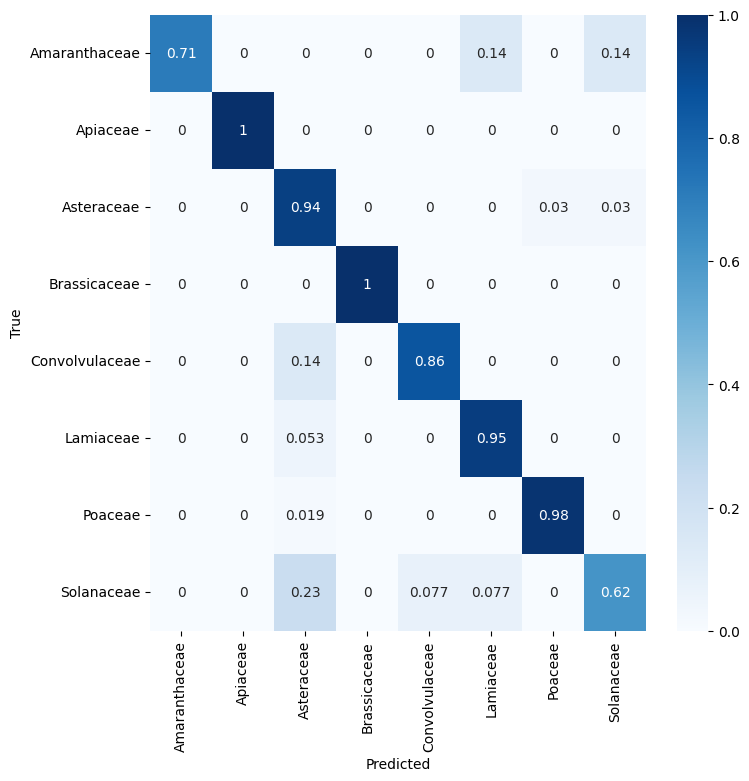

                precision    recall  f1-score   support

 Amaranthaceae       1.00      0.71      0.83         7
      Apiaceae       1.00      1.00      1.00         7
    Asteraceae       0.84      0.94      0.89        33
  Brassicaceae       1.00      1.00      1.00         6
Convolvulaceae       0.86      0.86      0.86         7
     Lamiaceae       0.90      0.95      0.92        19
       Poaceae       0.98      0.98      0.98        52
    Solanaceae       0.80      0.62      0.70        13

      accuracy                           0.92       144
     macro avg       0.92      0.88      0.90       144
  weighted avg       0.92      0.92      0.91       144



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))
